In [318]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp
import pylab as P
from cvxpy import *
import matplotlib.pyplot as plt
import os
import copy

# Don't really need a class implementation, maybe useful later
class species(object):
    def __init__(self, Nres, strat_dist, lin, strat_p=0.1):
        if strat_dist == 'uniform':
            self.strategy = [np.random.uniform() for i in range(Nres)]
        elif strat_dist == 'binomial':
            self.strategy = np.random.choice([0, 1], size=(Nres), p=[1-strat_p, strat_p])
        else:
            print 'Incorrectly specified distribution: options include "uniform" and "binomial".'
        if np.sum(self.strategy)!= 0:
            self.strat_norm = self.strategy/np.float64(np.sum(self.strategy))
        else:
            self.strat_norm = np.float64(self.strategy)
        self.fitness = np.exp(np.random.normal(0, 0.0001))
        self.norm_fit = self.fitness
        self.cost = 1
        self.lineage = lin
    
    def perturb_fitness(self, epsilon):
        self.fitness = self.fitness*np.exp(np.random.normal(0, epsilon))
        return
    
    def normalize_fitness(self, av_fit):
        self.norm_fit = self.fitness/av_fit
        return
    
    def perturb_strategy(self, n=1):
        idx = np.random.choice(range(len(self.strategy)))
        self.strategy[idx] = 1-self.strategy[idx]
        if np.sum(self.strategy)!= 0:
            self.strat_norm = self.strategy/np.float64(np.sum(self.strategy))
        else:
            self.strat_norm = np.float64(self.strategy)
        return
    
    def perturb_strategy_cont(self, epsilon):
        self.strategy = self.strategy+[epsilon*np.random.normal() for i in range(Nres)]
        self.strategy = self.strategy/np.sum(self.strategy)
        return

# Run optimization scheme        
def run_opt(vspecies, vres):
    
    Nspec = len(vspecies)
    Nres = len(vres)
    
    A = np.array([vspecies[i].norm_fit*vspecies[i].strat_norm for i in range(Nspec)])
    b = np.array([vspecies[i].cost for i in range(Nspec)])
    h = Variable(Nres)

    # The objective to be minimized is f = -R_i*log(h_i)
    # subject to the constraints \sigma_\mu . h = \chi_\mu.  
    # We use relaxed inequality constraints (but end up on
    # the boundary defined by the equalities, as expected)

    obj = Minimize(-sum_entries(vres*log(h)))
    constraints = [A*h<=b]
    prob = Problem(obj, constraints)
    prob.solve()

    delta = np.squeeze(np.asarray(A*h.value))-b
    
    return np.ndarray.flatten(h.value), delta

# Run random environment with random initial species distribution
def run_rand_env(Nres, alpha):
    Nspec = int(alpha*Nres)

    #Uniform resource distribution
    #A = 1.0
    #vres = A*np.array([np.random.uniform() for i in range(Nres)])

    vres = np.ones(Nres)
    vspecies = [species(Nres, 'binomial', i) for i in range(Nspec)]
    h, delta = run_opt(vspecies, vres)

    # Numerical precision is 1e-6, so for |delta|<1e-6,
    # set to zero.
    present = []
    absent = []

    for i in range(Nspec):
        if np.abs(delta[i])<0.000001:
            present.append(vspecies[i])
        else:
            absent.append(vspecies[i])  
#   matplotlib.pyplot.plot(np.log(-delta),'.')
    return vres, h, present, absent

#    observable is np.sum(pres)/Nres

# Run specified environment
def run_spec_env(vres, vspecies):
    Nspec = len(vspecies)
    
    #run optimization scheme
    h, delta = run_opt(vspecies, vres)
    
    #presence/absence vector
    present = []
    absent = []
    
    # Numerical precision is 1e-6, so for |delta|<1e-6,
    # set to zero.
    for i in range(Nspec):
        if np.abs(delta[i])<0.000001:
            present.append(vspecies[i])
        else:
            absent.append(vspecies[i])
    return vres, h, present, absent

def evolve_fitness(vspecies, epsilon):
    newspec = []
    for s in vspecies:
        temp = copy.copy(s)
        temp.perturb_fitness(epsilon)
        newspec.append(temp)
    vspecies.extend(newspec)
    return vspecies

def evolve_strategy(vspecies):
    newspec = []
    for s in vspecies:
        temp = copy.copy(s)
        temp.perturb_strategy()
        newspec.append(temp)
    vspecies.extend(newspec)
    return vspecies

def evolve_fit_strat(vspecies, eps_fit, prob_fit, prob_strat):
    newspec = []
    for s in vspecies:
        fitcoin = np.random.uniform()
        stratcoin = np.random.uniform()
        if fitcoin <= prob_fit or stratcoin <= prob_strat:
            temp = copy.copy(s)
            if fitcoin <= prob_fit:
                temp.perturb_fitness(eps_fit)
            if stratcoin <= prob_strat:
                temp.perturb_strategy()
            newspec.append(temp)
    vspecies.extend(newspec)
    av_fit = 0
    for s in vspecies:
        av_fit=av_fit+s.fitness
    for s in vspecies:
        s.normalize_fitness(av_fit/len(vspecies))
    return vspecies

def generate_h_series(Nres, alpha, T, eps_fit, prob_fit, prob_strat):
    fossil = []
    vh = []
    
    vres, h, present, absent = run_rand_env(Nres, alpha)
    fossil.append(absent)
    vh.append(h)
    nspec = [len(present)]
    for i in range(T):
        present = evolve_fit_strat(present, eps_fit, prob_fit, prob_strat)
        vres, h, present, absent = run_spec_env(vres, present)
        fossil.append(absent)
        vh.append(h)
        nspec.append(len(present))
    return vres, vh, present, fossil, nspec

def generate_var_h(Nres, alpha, T, eps_fit, prob_fit, prob_strat):
    varh = []
    
    vres, h, present, absent = run_rand_env(Nres, alpha)
    varh.append(np.var(h))
    for i in range(T):
        present = evolve_fit_strat(present, eps_fit, prob_fit, prob_strat)
        vres, h, present, absent = run_spec_env(vres, present)
        varh.append(np.var(h))
    return varh

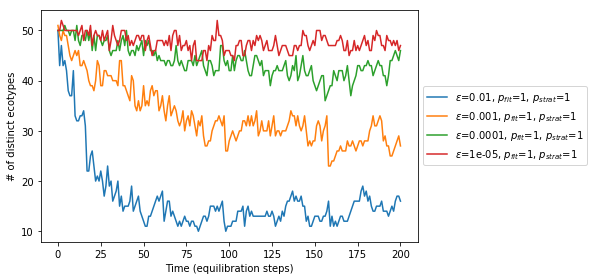

In [322]:
Nres=50
alpha = 4
T = 200
eps_fit = [0.01,0.001,0.0001, 0.00001]
prob_fit = [1]
prob_strat = [1]

ax = plt.subplot(111)

for i in eps_fit:
    for j in prob_fit:
        for k in prob_strat:
            vres, vh, present, fossil, nspec = generate_h_series(Nres, alpha, T, i, j, k)
            ax.plot(nspec, label='$\epsilon$='+str(i)+', $p_{fit}$='+str(j)+', $p_{strat}$='+str(k))
ax.set_xlabel('Time (equilibration steps)')
ax.set_ylabel('# of distinct ecotypes')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('nspec_mut_var.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

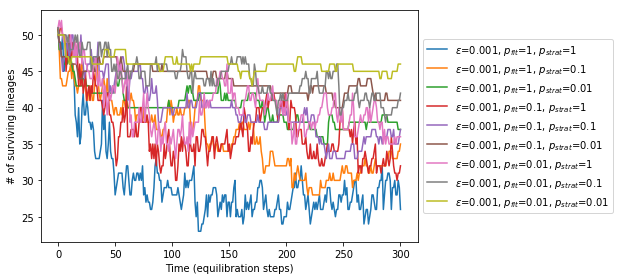

In [317]:
Nres=50
alpha = 4
T = 300
eps_fit = [0.001]
prob_fit = [1, 0.1, 0.01]
prob_strat = [1, 0.1, 0.01]

ax = plt.subplot(111)

for i in eps_fit:
    for j in prob_fit:
        for k in prob_strat:
            vres, vh, present, fossil, nspec = generate_h_series(Nres, alpha, T, i, j, k)
            ax.plot(nspec, label='$\epsilon$='+str(i)+', $p_{fit}$='+str(j)+', $p_{strat}$='+str(k))
ax.set_xlabel('Time (equilibration steps)')
ax.set_ylabel('# of distinct ecotypes')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('nspec_mut_var_sep_fit_strat.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()


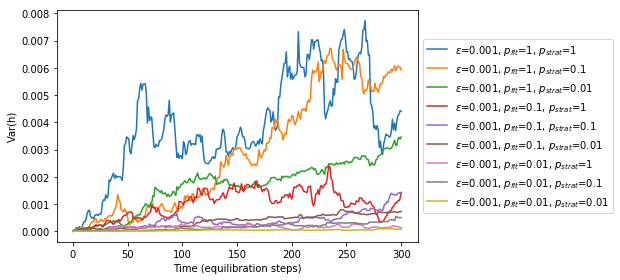

In [319]:
Nres=50
alpha = 4
T = 300
eps_fit = [0.001]
prob_fit = [1, 0.1, 0.01]
prob_strat = [1, 0.1, 0.01]

ax = plt.subplot(111)

for i in eps_fit:
    for j in prob_fit:
        for k in prob_strat:
            varh = generate_var_h(Nres, alpha, T, i, j, k)
            ax.plot(varh, label='$\epsilon$='+str(i)+', $p_{fit}$='+str(j)+', $p_{strat}$='+str(k))
ax.set_xlabel('Time (equilibration steps)')
ax.set_ylabel('Var(h)')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('varh_mut_var_sep_fit_strat.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()